## Heuristic Code

In [1]:
import igraph as ig
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import itertools
import operator
import networkx as nx

import warnings
warnings.filterwarnings('ignore')


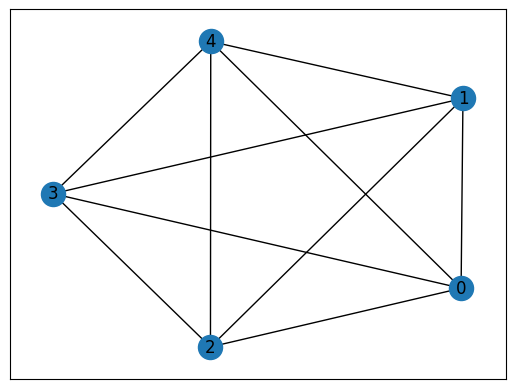

In [2]:
from networkx.generators.random_graphs import erdos_renyi_graph
import networkx as nx

v = 5
p = 1
G = erdos_renyi_graph(v, p)
#G = nx.barabasi_albert_graph(100, 2)
E=[]
for i in G.edges:
  E.append(i)

allowedWeightValues = list(range(1,5))  #allowedWeightValues = [1, 2, 3, 4, 5]
noOfEdges = len(E)
g = ig.Graph(v, E)

nx.draw_networkx(G)

In [3]:
def findSEPR(path, WT):
  sEPR = max(WT)
  for i in range(len(path[0])-1):
    if (path[0][i],path[0][i+1]) in E:
      index = E.index((path[0][i],path[0][i+1]))
    else:
      index = E.index((path[0][i+1],path[0][i]))
    if sEPR >= WT[index]:
      sEPR = WT[index]
  return sEPR
def updatePathWeight(path, pathWeight, updateFactor):
  for i in range(len(path[0])-1):
    if (path[0][i],path[0][i+1]) in E:
      index = E.index((path[0][i],path[0][i+1]))
    else:
      index = E.index((path[0][i+1],path[0][i]))
    pathWeight[index] = pathWeight[index] - updateFactor
  return pathWeight

In [4]:
def intersection(lst1, lst2):
    temp = set(lst2)
    lst3 = [value for value in lst1 if value in temp]
    return lst3

In [5]:
AllPath = dict()
def getAllShortestPath(NodePairs):
  AllPath.clear()
  for (x,y) in NodePairs:
    if AllPath.get(x) == None:
      AllPath[x] = {}
    AllPath[x][y] = [p for p in nx.all_simple_paths(G, x, y)]

In [6]:
AllPathsEPR = dict()
def getAllsEPR(NodePairs, WT):
  AllPathsEPR.clear()
  for (x,y) in NodePairs:
    if AllPathsEPR.get(x) == None:
      AllPathsEPR[x] = {}
    if AllPathsEPR[x].get(y) == None:
      AllPathsEPR[x][y] = {}
    k=0
    for p in AllPath[x][y]:
      AllPathsEPR[x][y][k] = findSEPR([p],WT)
      k+=1

In [7]:
def splitSchedulingLP(SN):
  RD,RDT,RsPathL,RsPaths,RDN, RST = [list(t) for t in zip(*SN)]
  T = max(RDT)
  SCHD = [[] for i in range(0,T)]
  WT = [[x for x in W] for i in range(0,T)]
  EPRServed = 0
  DServed = 0
  allocation = []
  for i in range(len(RD)):
    RX = [p for p in nx.all_simple_paths(G, RDN[i][0], RDN[i][1], 5)]
    RX.sort(key=len)
    # print(f'For Demand {i} between {(RDN[i][0], RDN[i][1])}, Demand Size: {RD[i]}')
    for counter, path in enumerate(RX):
      if RD[i]>0:
        t = RST[i]
        while t < RDT[i] and RD[i]>0:
          sEPR = findSEPR([path], WT[t])
          if sEPR>0:
            if RD[i] > sEPR:
              SCHD[t].append((RDN[i],sEPR))
              for f, s in zip(path, path[1:]):
                # allocation.append((t, i, (f,s), (RDN[i][0], RDN[i][1]), sEPR))
                allocation.append((t, (f,s), (RDN[i][0], RDN[i][1]), sEPR))
                # print(f'allocation on edge {(f,s)}: {sEPR}')
              EPRServed += sEPR
              RD[i] -= sEPR
              WT[t] = updatePathWeight([path], WT[t], sEPR)
              t = t + 1
            else:
              EPRServed += RD[i]
              WT[t] = updatePathWeight([path], WT[t], RD[i])
              SCHD[t].append((RDN[i],RD[i]))
              for f, s in zip(path, path[1:]):
                # allocation.append((t, i, (f,s), (RDN[i][0], RDN[i][1]), RD[i]))
                allocation.append((t, (f,s), (RDN[i][0], RDN[i][1]), RD[i]))
                # print(f'allocation on edge {(f,s)}: {RD[i]}')
              RD[i] = 0
              DServed += 1
              break
          else:
            t = t + 1;
      else:
        break
  return EPRServed, SCHD, DServed, allocation

## LP Code

In [8]:
import pandas as pd
import numpy as np
import random
import networkx as nx
import matplotlib.pyplot as plt
from docplex.mp.model import Model
from docplex.mp.vartype import VarType
import json

In [9]:
def generate_weight_matrix(nb_nodes, p, min_weight, max_weight, debug=False):
    # er_graph = np.random.choice([0, 1], size=(nb_nodes, nb_nodes), p=[1 - p, p])
    # np.fill_diagonal(er_graph, 0)   
    G = nx.erdos_renyi_graph(nb_nodes, p)
    er_graph = nx.to_numpy_array(G)
    weights = np.random.randint(min_weight, max_weight, size=(nb_nodes, nb_nodes))
    W_adj = er_graph * weights
    W_adj = (W_adj + W_adj.T) // 2
    if debug:
        print(f"Weight Matrix:\n{W_adj}")
    return G, W_adj

In [43]:
def generate_demands(nb_demands, nb_nodes, nb_timesteps, max_eprs, debug=False):
    demand_sizes = np.random.randint(1, max_eprs, size=nb_demands)

    all_pairs = []
    for i in range(nb_nodes):
        for j in range(nb_nodes):
            if i != j:
                all_pairs.append((i, j))
    demand_pairs = random.choices(all_pairs, k=nb_demands)
    start_nodes, end_nodes = list(zip(*demand_pairs))

    all_intervals = []
    for i in range(nb_timesteps):
        for j in range(i + 1, nb_timesteps):
            all_intervals.append((i, j))
    demand_intervals = random.choices(all_intervals, k=nb_demands)
    start_times, end_times = list(zip(*demand_intervals))

    return start_nodes, end_nodes, demand_sizes, start_times, end_times

In [11]:
def create_digraph(W_adj):
    nb_nodes = W_adj.shape[0]
    labels = [i for i in range(nb_nodes)]
    W_df = pd.DataFrame(W_adj, index=labels, columns=labels)
    G_digraph = nx.from_pandas_adjacency(W_df, create_using=nx.DiGraph())
    return G_digraph

In [12]:
def plot_digraph(G, filename):
    plt.figure()
    positions = nx.spring_layout(G)
    nx.draw_networkx_nodes(G, positions)
    nx.draw_networkx_edges(G, pos=positions, width=1.0)
    edge_labels = {(u, v): d["weight"] for u, v, d in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, positions, edge_labels=edge_labels)
    nx.draw_networkx_labels(G, positions)
    # plt.savefig(filename)
    plt.show()

In [13]:
def add_variables(model, W_adj, nb_demands, nb_timesteps, nb_nodes, debug=False):
    variables = model.integer_var_dict(
        [
            (i, t, u, v)
            for i in range(nb_demands)
            for t in range(nb_timesteps)
            for u in range(nb_nodes)
            for v in range(nb_nodes)
            if W_adj[u][v] != 0
        ],
        name="f",
    )
    if debug:
        for var_key in variables:
            print(variables[var_key].name)
    return variables

In [14]:
def define_multiobjective(model, W_adj, nb_demands, nb_nodes, demand_list, variables, debug=False):
  objectives = []
  for i in range(nb_demands):
    source_outflow = model.linear_expr()
    for t in range(demand_list[i][3], demand_list[i][4], 1):
      for v in range(nb_nodes):
        if W_adj[demand_list[i][0]][v] != 0:
          source_outflow += variables[(i, t, demand_list[i][0], v)]
    objectives.append(source_outflow)
  model.set_multi_objective('max', objectives, abstols = None, reltols = None, names = None)

In [15]:
def define_objective(model, W_adj, nb_demands, nb_nodes, demand_list, variables, debug=False):
    objective = 0
    for i in range(nb_demands):
        for t in range(demand_list[i][3], demand_list[i][4], 1):
            for v in range(nb_nodes):
                if W_adj[demand_list[i][0]][v] != 0:
                    if debug: 
                        print(
                            (i, t, demand_list[i][0], v),
                            variables[(i, t, demand_list[i][0], v)],
                        )
                        print()
                    objective += (
                        variables[(i, t, demand_list[i][0], v)]
                    )
    model.maximize(objective)

In [16]:
def define_constraints(
    model,
    W_adj,
    nb_timesteps,
    nb_demands,
    nb_nodes,
    demand_list,
    variables,
    nw_state,
    debug=False,
):
    # Flow Conservation Constraint:
    for i in range(nb_demands):
        for t in range(nb_timesteps):
            for v in range(nb_nodes):
                if v not in (demand_list[i][0], demand_list[i][1]):
                    inflow_v = model.linear_expr()
                    outflow_v = model.linear_expr()
                    for u in range(nb_nodes):
                        if W_adj[u][v] != 0:
                            inflow_v += variables[(i, t, u, v)]
                            outflow_v += variables[(i, t, v, u)]
                    if debug:
                        print(f"INFLOW_I_{i}_T_{t}_V_{v} = {inflow_v}")
                        print(f"OUTFLOW_I_{i}_T_{t}_V_{v} = {outflow_v}")
                    model.add_constraint(
                        inflow_v == outflow_v, f"flow_cons_node_i_{i}_t_{t}_v_{v}"
                    )
                    if debug:
                        print(
                            model.get_constraint_by_name(
                                f"flow_cons_node_i_{i}_t_{t}_v_{v}"
                            )
                        )

    # The Capacity Constraint:
    for t in range(nb_timesteps):
        for u in range(nb_nodes):
            for v in range(nb_nodes):
                if W_adj[u][v] != 0:
                    sum_allocated = model.linear_expr()
                    for i in range(nb_demands):
                        sum_allocated += variables[(i, t, u, v)] + variables[(i, t, v, u)]
                    model.add_constraint(
                        sum_allocated <= nw_state[t][u][v],
                        f"edge_capacity_{u}_{v}_t_{t}",
                    )
                    if debug:
                        print(
                            model.get_constraint_by_name(f"edge_capacity_{u}_{v}_t_{t}")
                        )
                        print()
    
    # The Out-of-Window Constraint:
    total_allocation = model.linear_expr()
    for i in range(nb_demands):
        demand_allocation = model.linear_expr()
        dont_allocate_time = [
            t
            for t in range(0, nb_timesteps)
            if t not in range(demand_list[i][3], demand_list[i][4])
        ]
        if debug:
            print(
                f"dont allocate time for req: {demand_list[i]} = {dont_allocate_time}"
            )
        for t in dont_allocate_time:
            for u in range(nb_nodes):
                for v in range(nb_nodes):
                    if W_adj[u][v] != 0:  # edge u->v
                        demand_allocation += variables[(i, t, u, v)]
        total_allocation += demand_allocation 
        # model.add_constraint(sum_allocated == 0, f"no_allocation_bef_after_req_{i}")
    # DEBUG PRINTING
    model.add_constraint(total_allocation == 0, f"no_oow_allocation") 
    if debug:
        print(model.get_constraint_by_name(f"no_oow_allocation"))
        print()
    
    # The Demand Size Constraint:
    for i in range(nb_demands):
        source_outflow = model.linear_expr()
        for t in range(demand_list[i][3], demand_list[i][4], 1):
            sum_allocated = model.linear_expr()
            u = demand_list[i][0]
            for v in range(nb_nodes):
                if W_adj[u][v] != 0:  # edge from  u -> v
                    source_outflow += variables[(i, t, u, v)]
            # model.add_constraint(
            #     sum_allocated <= demand_list[i][2],
            #     f"max_allocation_demand_{i}_t_{t}",
            # )

        dest_inflow = model.linear_expr()
        for t in range(demand_list[i][3], demand_list[i][4], 1):
            sum_allocated = model.linear_expr()
            v = demand_list[i][1]
            for u in range(nb_nodes):
                if W_adj[u][v] != 0:  # edge from  u -> v
                    dest_inflow += variables[(i, t, u, v)]
            # model.add_constraint(
            #     sum_allocated <= demand_list[i][2],
            #     f"max_allocation_demand_{i}_t_{t}",
            # )
        model.add_constraint(
            source_outflow <= demand_list[i][2],
            f"demand_size_{i}"
        )
        model.add_constraint(
            dest_inflow == source_outflow,
            f"dest_demand_size_{i}"
        )
        if debug:
            print(model.get_constraint_by_name(f"max_allocation_demand_{i}_t_{t}"))
            print()

    #Any inflow into the source vertex should be 0 wrt that demand and outflow at the dest vertex should be 0
    source_inflow_dest_outflow = model.linear_expr()
    for i in range(nb_demands):
        #incoming edges into src
        for t in range(demand_list[i][3], demand_list[i][4], 1):
            for v in range(nb_nodes):
                if W_adj[v][demand_list[i][0]] != 0:
                    source_inflow_dest_outflow += variables[(i, t, v, demand_list[i][0])]
        
        #outgoing edges from dest
        for t in range(demand_list[i][3], demand_list[i][4], 1):
            for v in range(nb_nodes):
                if W_adj[demand_list[i][1]][v] != 0:
                    source_inflow_dest_outflow += variables[(i, t, demand_list[i][1], v)]
    
    model.add_constraint(
            source_inflow_dest_outflow == 0,
            "inflow_src_outflow_dst"
        )
    
    print(model.get_constraint_by_name("inflow_src_outflow_dst"))
    print()
        

    # # Constraint 1
    # source_outflow = []
    # for i in range(nb_demands):
    #     sum_allocated = model.linear_expr()
    #     for t in range(demand_list[i][3], demand_list[i][4], 1):
    #         for v in range(nb_nodes):
    #             if W_adj[demand_list[i][0]][v] != 0:
    #                 sum_allocated += variables[(i, t, demand_list[i][0], v)]
    #     model.add_constraint(
    #         sum_allocated <= demand_list[i][2],
    #         f"outflow_src_demand_{i}_src_{demand_list[i][0]}",
    #     )
    #     source_outflow.append(sum_allocated)
    #     if debug:
    #         print(
    #             model.get_constraint_by_name(
    #                 f"outflow_src_demand_{i}_src_{demand_list[i][0]}"
    #             )
    #         )
    #         print()

    # # Constraint 2
    # for i in range(nb_demands):
    #     sum_allocated = model.linear_expr()
    #     for t in range(demand_list[i][3], demand_list[i][4], 1):
    #         for u in range(nb_nodes):
    #             if W_adj[u][demand_list[i][1]] != 0:
    #                 sum_allocated += variables[(i, t, u, demand_list[i][1])]
    #     model.add_constraint(
    #         sum_allocated == source_outflow[i],
    #         f"inflow_dest_demand_{i}_dst_{demand_list[i][1]}",
    #     )
    #     if debug:
    #         print(
    #             model.get_constraint_by_name(
    #                 f"inflow_dest_demand_{i}_dst_{demand_list[i][1]}"
    #             )
    #         )
    #         print()
    


In [17]:
def generate_flow_matrix(vars, nb_demands, nb_timesteps, nb_nodes, debug=False):
    F = np.zeros(shape=(nb_demands, nb_timesteps, nb_nodes, nb_nodes))
    # print("")
    # print("")
    # print("FLOWS")
    # print("-------------------")
    # print("[i, t, u, v] | flow")
    # print("-------------------")
    for v in vars:
        if v["value"] != 0:
            id = v["name"]
            id = id.split("_")[1:]
            id = list(map(int, id))
            F[id[0], id[1], id[2], id[3]] = float(v["value"])
            # print(f"{id} | {v['value']}")
    # print("-------------------")
    return F

In [18]:
def compute_served(F, demand_list):
    nb_demands = len(demand_list)
    served_count = 0
    total_eprs = 0
    for i in range(nb_demands):
        eprs_served = 0
        for t in range(F.shape[1]):
            for v in range(F.shape[2]):
                eprs_served += F[i][t][demand_list[i][0]][v]
        if eprs_served == demand_list[i][2]:
            served_count += 1
            # print(f"Served demand {i}")
        total_eprs += eprs_served

    # print(f"Served {served_count} out of {nb_demands} demands.")
    return served_count, total_eprs

**vDensity**

In [19]:
def path_and_time_intersection(p1, p2, st1, et1, st2, et2):
  if (et1<=st2) or (et2<=st1):
    return []
  temp = set(p2)
  lst3 = [value for value in p1 if value in temp]
  return lst3

In [20]:
from tabulate import tabulate

def make_table(allocation):
    allocation = sorted(allocation, key=lambda x: x[2])
    table = tabulate(allocation, headers=['Time', 'Edge', 'Demand', 'EPR Allocated'],tablefmt='grid')
    print(table)
    return table


In [21]:
def parse_lp(vars, demand_list):
    # for i in range(nb_demands):
    #     for t in range(nb_timesteps):
    #         for u in range(nb_nodes):
    #             for v in range(nb_nodes):
    #                 if W_adj[u][v] != 0:
    allocation = []
    for v in vars:
        if v["value"] != 0:
            id = v["name"]
            id = id.split("_")[1:]
            id = list(map(int, id))
            # allocation.append((id[1], id[0], (id[2],id[3]), demand_list[id[0]], v["value"]))
            allocation.append((id[1], (id[2],id[3]), demand_list[id[0]], v["value"]))
    # print('Allocation for LP:')
    # make_table(allocation)
    return allocation

In [22]:
def cmp_allocation(alloc_hr, alloc_lp, dem_lst, D):
    for idx in range(len(dem_lst)):
        dem_alloc_hr, dem_alloc_lp = [], []
        # for a in alloc_hr:
        #     if a[1] == idx:
        #         dem_alloc_hr.append(a)
        # for a in alloc_lp:
        #     if a[1] == idx:
        #         dem_alloc_lp.append(a)
        for a in alloc_hr:
            if a[2] == dem_lst[idx]:
                dem_alloc_hr.append(a)
        for a in alloc_lp:
            if a[2] == dem_lst[idx]:
                dem_alloc_lp.append(a)
        print(f'For demand: {dem_lst[idx]} with demand size: {D[idx]}')
        print('Heuristic')
        make_table(dem_alloc_hr)
        print('LP')
        make_table(dem_alloc_lp)
        idx+=1

In [23]:
def edge_allocation(alloc_hr, alloc_lp, edges, edge_wts, T):
    print(edges)
    edge_alloc_hr, edge_alloc_lp = [], []
    for idx, e in enumerate(edges):
        for t in range(T):
            alloc_e_t_hr = 0
            for a in alloc_hr:
                # print(f'a[1]: {a[1]}, e:{e}, a[0]:{a[0]} and t:{t}')
                if (a[1] == e or a[1] == e[::-1]) and a[0] == t:
                    # print('matched')
                    alloc_e_t_hr += a[3]
            edge_alloc_hr.append((e, t, alloc_e_t_hr, edge_wts[idx]))

            alloc_e_t_lp = 0
            for a in alloc_lp:
                # print(f'a[1]: {a[1]}, e:{e}, a[0]:{a[0]} and t:{t}')
                if (a[1] == e or a[1] == e[::-1]) and a[0] == t:
                    # print('matched')
                    alloc_e_t_lp += float(a[3])
            edge_alloc_lp.append((e, t, alloc_e_t_lp, edge_wts[idx]))
    table = tabulate(edge_alloc_hr, headers=['Edge', 'Time', 'Total EPR Allocated', 'Capacity'],tablefmt='grid')
    print(table)
    table = tabulate(edge_alloc_lp, headers=['Edge', 'Time', 'Total EPR Allocated', 'Capacity'],tablefmt='grid')
    print(table)

In [ ]:

from networkx.generators.random_graphs import erdos_renyi_graph
import networkx as nx
from numpy import arange
import time

lowerBound = 0.1
upperBound = 1.0
step = 0.1
iteration = (upperBound-lowerBound)//step
edge = []

#To ensure probabilistic nature, we need to repeat each 'number_of_demands' multiple times and average out for each 'number_of_demands'
average_eprres = [0 for i in arange(lowerBound, upperBound, step)]
average_dres = [0 for i in arange(lowerBound, upperBound, step)]

average_eprres_lp = [0 for i in arange(lowerBound, upperBound, step)]
average_dres_lp = [0 for i in arange(lowerBound, upperBound, step)]

num_trials = 1


v = 25

"""
    To compute the execution times, we are:
      1. Computing and caching the graphs for every graph density value
      2. Running Heuristic and saving for all values of graph density from 0.1 to 1 
      (because LP gets stuck and won't run after a certain graph density)
      3. Run LP for all values of graph density
"""

for trial in range(num_trials):
  # Heuristic Part

  print('trial:', trial)
  k = 200
  allowedWeightValues = list(range(1,5))
  eprres = []
  dres = []
  eprres_lp = []
  dres_lp = []

  all_graphs = []
  all_W_adjs = []
  exec_tms_heur = []
  exec_tms_lp = []
  densities = []
  # DN=[(0, 3), (0, 2), (3, 2), (1, 3), (1, 0), (0, 1), (1, 2), (3, 4), (4, 0), (3, 1), (2, 3), (4, 1), (1, 4), (2, 0), (4, 3)]
  # D=[8 ,13 ,14 ,9 ,12 ,2 ,4 ,14 ,12 ,5 ,1 ,7 ,11 ,13 ,12]
  # DST=(0, 3, 4, 4, 1, 1, 4, 6, 5, 3, 4, 6, 6, 4, 0)
  # DT=(2, 9, 8, 7, 8, 6, 5, 7, 8, 8, 5, 9, 9, 9, 9)
  # start_nodes=(0, 0, 3, 1, 1, 0, 1, 3, 4, 3, 2, 4, 1, 2, 4)
  # end_nodes=(3, 2, 2, 3, 0, 1, 2, 4, 0, 1, 3, 1, 4, 0, 3)
  # DN=[(4,3), (3,4)]
  # D=[12, 14]
  # DST=[0, 6]
  # DT=[9, 7]
  # start_nodes=[4, 3]
  # end_nodes=[3, 4]
  start_nodes, end_nodes, D, DST, DT = generate_demands(nb_demands=k, nb_nodes=v, nb_timesteps=10, max_eprs=15)
  DN = list(zip(start_nodes, end_nodes))
  # DN = random.sample(list((x,y) for x,y in itertools.product(range(v), repeat = 2) if x!=y), k=k) # Demand Nodes (start_node, end_node)
  # D = random.choices(list(range(1,15)), k=k) # Demand Sizes
  # DT = random.choices(list(range(5,10)), k=k) #End Time
  # DST = random.choices(list(range(0,5)), k=k) #Start time for each demand
  BurstDuration = [DT[i] - DST[i] for i in range(len(D))]
  Demands = list(zip(start_nodes, end_nodes, D, DST, DT, DN))
  print('Demands:')
  print(tabulate(Demands, headers=['Start Node', 'End Node', 'Demand Size', 'Start Time', 'End Time', 'DN'],tablefmt='grid'))
  results_heuristic = {}
  
  #1. Caching the graphs
  for density in arange(lowerBound, upperBound, step):
    if density>0.2 and density<0.5:
      print(f'density:{density} skipped')
      continue
    print('density:', density)
    densities.append(density)
    G, W_adj = generate_weight_matrix(v, density, 1, 5)
    all_graphs.append(G)
    all_W_adjs.append(W_adj)
    # W_adj = np.array([[0,0,0,3,0]
    #               ,[0,0,3,2,0]
    #               ,[0,3,0,0,2]
    #               ,[3,2,0,0,1]
    #               ,[0,0,2,1,0]])
    # G  = nx.from_numpy_array(W_adj)
  
  print(f'densities: {densities}')
  
  #2. Running Heuristic
  for i in range(len(densities)):
    #---REPEAT IN LP START------
    print(f'HEUR density: {densities[i]}')
    G = all_graphs[i]
    W_adj = all_W_adjs[i]
    nx.draw_networkx(G)
    print(W_adj)

    E=[]
    for j in G.edges:
      print(f'edge j:{j}')
      E.append(j)
    W_prime = np.triu(W_adj)
    W = list(W_prime[W_prime != 0])
    print(f'W, E: {W, E}')
    noOfEdges = len(E)
    edge.append(noOfEdges)
    g = ig.Graph(v, E)
    
    sPaths = list()
    sPathL = []
    for j in DN:
      shortestPath = g.get_shortest_paths(j[0], to=j[1], output="vpath")
      sPaths.append(shortestPath)
      sPathL.append(len(shortestPath[0])-1)
    ST  = [0 for a in range(len(D))]
    m = 0
    Paths = sPaths
    P = [0 for i in range(len(Paths))]
    for l in Paths:
      P[m] = []
      for q in l:
        for i in range(len(q)-1):
          P[m].append((q[i], q[i+1]))
      m += 1
    
    S = sorted(zip(D, DT, sPathL, sPaths, DN, DST), key = lambda x: (x[1], x[0], x[2])) #EPR Maximization --- sorted
    # print(f'after zipping demands -----')
    # for tup in S:
    #   print(tup)
    # print('-----')
    #---REPEAT IN LP END------

    Tstart_heur = time.perf_counter()
    eprserved, schd, dserved, allocation_hr = splitSchedulingLP(S)
    eprres.append(eprserved/sum(D))
    dres.append(dserved/len(D))
    results_heuristic[str(round(density,3))]=[eprserved, dserved, schd]
    Tend_heur = time.perf_counter()
    print(f'eprserved: {eprserved}')
    print(f'Time taken HEUR: {Tend_heur-Tstart_heur}')
    exec_tms_heur.append(Tend_heur-Tstart_heur)
    # print('Allocation for Heuristic:')
    # make_table(allocation_hr)
    
  print(f'Heuristic SUCCESS: Exec Times ->{exec_tms_heur}')  
  print(f'eprres: {eprres}')

  #LP Part
  # print(densities)

  # del densities[2]
  # del densities[2]
  # densities.append(0.3)
  # densities.append(0.4)

  # print(densities)
  # import sys
  # sys.exit()

  # all_graphs.append(all_graphs[2])
  # all_graphs.append(all_graphs[3])
  # del all_graphs[2]
  # del all_graphs[2]

  # all_W_adjs.append(all_W_adjs[2])
  # all_W_adjs.append(all_W_adjs[3])
  # del all_W_adjs[2]
  # del all_W_adjs[2]

  for i in range(len(densities)):
    print(f'LP density: {densities[i]}')
    #---REPEAT IN LP START------
    G = all_graphs[i]
    W_adj = all_W_adjs[i]
    nx.draw_networkx(G)
    print(W_adj)

    E=[]
    for j in G.edges:
      print(f'edge j:{j}')
      E.append(j)
    W_prime = np.triu(W_adj)
    W = list(W_prime[W_prime != 0])
    print(f'W, E: {W, E}')
    noOfEdges = len(E)
    edge.append(noOfEdges)
    g = ig.Graph(v, E)
    
    sPaths = list()
    sPathL = []
    for j in DN:
      shortestPath = g.get_shortest_paths(j[0], to=j[1], output="vpath")
      sPaths.append(shortestPath)
      sPathL.append(len(shortestPath[0])-1)
    ST  = [0 for a in range(len(D))]
    m = 0
    Paths = sPaths
    P = [0 for i in range(len(Paths))]
    for l in Paths:
      P[m] = []
      for q in l:
        for i in range(len(q)-1):
          P[m].append((q[i], q[i+1]))
      m += 1
    
    S = sorted(zip(D, DT, sPathL, sPaths, DN, DST), key = lambda x: (x[1], x[0], x[2])) #EPR Maximization --- sorted
    # print(f'after zipping demands -----')
    # for tup in S:
    #   print(tup)
    # print('-----')
    #---REPEAT IN LP END------
    network_state = [W_adj] * (10 + 1)
    Tstart_lp = time.perf_counter()
    model = Model(name="routing", log_output=False)
    model.objective_sense = "max"
    model.parameters.threads.set(1)
    G_base = create_digraph(W_adj)
    variables = add_variables(model=model, W_adj=W_adj,nb_demands=k, nb_timesteps=10, nb_nodes=v)
    # define_multiobjective(model=model, W_adj=W_adj, nb_demands=k, nb_nodes=v, demand_list=list(zip(start_nodes, end_nodes, D, DST, DT)), variables=variables)                                                                     
    define_objective(model=model, W_adj=W_adj, nb_demands=k, nb_nodes=v, demand_list=list(zip(start_nodes, end_nodes, D, DST, DT)), variables=variables)
    define_constraints(model=model, W_adj=W_adj, nb_timesteps=10, nb_demands=k, nb_nodes=v, demand_list=list(zip(start_nodes, end_nodes, D, DST, DT)), variables=variables, nw_state=network_state)
    solution = model.solve()
    Tend_lp = time.perf_counter()
    print(f'Time taken LP: {Tend_lp-Tstart_lp}')
    exec_tms_lp.append(Tend_lp-Tstart_lp)
    if solution is None:
      dserved_lp = eprsserved_lp = 0
    else:
      sol_json = solution.export_as_json_string()
      vars = json.loads(sol_json)["CPLEXSolution"]["variables"]
      F = generate_flow_matrix(vars, nb_demands=k, nb_timesteps=10, nb_nodes=v, debug=True)
      dserved_lp, eprserved_lp = compute_served(F, list(zip(start_nodes, end_nodes, D, DST, DT)))
      # allocation_lp = parse_lp(vars,list(zip(start_nodes, end_nodes)))
      print(f'eprserved_lp: {eprserved_lp}')
      # print('-----Demand by Demand Comparison-----')
      # print('eprserved heuristic: ', eprserved)
      # print('eprserved_lp: ', eprserved_lp)
      # cmp_allocation(allocation_hr, allocation_lp, list(zip(start_nodes, end_nodes)), D)
      # edge_allocation(allocation_hr, allocation_lp, E, W, 10)


    eprres_lp.append(eprserved_lp/sum(D))
    dres_lp.append(dserved_lp/len(D))
  
  print(f'LP SUCCESS: Exec Times ->{exec_tms_lp}')  
  print(f'epeprres_lp: {eprres_lp}')
    

  for i in range(len(eprres)):
    position = i
    average_eprres[position] = average_eprres[position] + eprres[position]
    average_dres[position] = average_dres[position] + dres[position]
    
    average_eprres_lp[position] = average_eprres_lp[position] + eprres_lp[position]
    average_dres_lp[position] = average_dres_lp[position] + dres_lp[position]
    
  for i in range(len(eprres)):
    position = i
    average_eprres[position] = average_eprres[position]/num_trials
    average_dres[position] = average_dres[position]/num_trials
    
    average_eprres_lp[position] = average_eprres_lp[position]/num_trials
    average_dres_lp[position] = average_dres_lp[position]/num_trials

[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 3. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 2. 0. 2. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 3. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 3. 0.]
 [0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 2. 0. 3. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 3. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 3. 0. 0. 0. 0. 2.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 2.]
 [0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 3. 0. 3. 0.]
 [0. 0. 0. 2. 0. 0. 0. 0. 2. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 2. 0. 0. 3. 0. 1. 1.]
 [0. 0. 1. 3. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0.]
 [0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 2. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 3. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 3. 0.

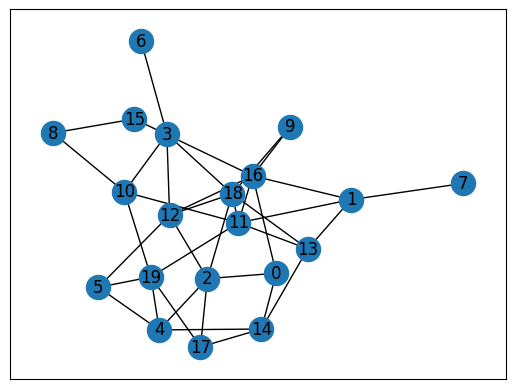

In [53]:

from networkx.generators.random_graphs import erdos_renyi_graph
import networkx as nx
from numpy import arange
import time

max_number_of_demands = 4000
lowerBound = 50
step = 300
num_trials = 1
v = 20

#To ensure probabilistic nature, we need to repeat each 'number_of_demands' multiple times and average out for each 'number_of_demands'
average_eprres = [0 for i in arange(lowerBound, max_number_of_demands, step)]
average_dres = [0 for i in arange(lowerBound, max_number_of_demands, step)]

average_eprres_lp = [0 for i in arange(lowerBound, max_number_of_demands, step)]
average_dres_lp = [0 for i in arange(lowerBound, max_number_of_demands, step)]

exec_tms_heur = []
exec_tms_lp = []

#Topology generation
G, W_adj = generate_weight_matrix(v, 0.2, 1, 5)
nx.draw_networkx(G)
print(W_adj)
E=[]
for j in G.edges:
  E.append(j)
noOfEdges = len(E)
g = ig.Graph(v, E)
W_prime = np.triu(W_adj)
W = list(W_prime[W_prime != 0])


for trial in range(num_trials):
  # Heuristic Part

  print('trial:', trial)
  eprres = []
  dres = []
  eprres_lp = []
  dres_lp = []
  
  results_heuristic = {}
  for k in range(lowerBound, max_number_of_demands, step):
    print(f'no. of demands: {k}')
    start_nodes, end_nodes, D, DST, DT = generate_demands(nb_demands=k, nb_nodes=v, nb_timesteps=10, max_eprs=15)
    DN = list(zip(start_nodes, end_nodes))
    # DN = random.sample(list((x,y) for x,y in itertools.product(range(v), repeat = 2) if x!=y), k=k) # Demand Nodes (start_node, end_node)
    # D = random.choices(list(range(1,15)), k=k) # Demand Sizes
    # DT = random.choices(list(range(5,10)), k=k) #End Time
    # DST = random.choices(list(range(0,5)), k=k) #Start time for each demand
    BurstDuration = [DT[i] - DST[i] for i in range(len(D))]
    Demands = list(zip(start_nodes, end_nodes, D, DST, DT))
    print('Demands:')
    print(tabulate(Demands, headers=['Start Node', 'End Node', 'Demand Size', 'Start Time', 'End Time'],tablefmt='grid'))

    sPaths = list()
    sPathL = []
    for j in DN:
      shortestPath = g.get_shortest_paths(j[0], to=j[1], output="vpath")
      sPaths.append(shortestPath)
      sPathL.append(len(shortestPath[0])-1)
    ST  = [0 for a in range(len(D))]
    m = 0
    Paths = sPaths
    P = [0 for i in range(len(Paths))]
    for l in Paths:
      P[m] = []
      for q in l:
        for i in range(len(q)-1):
          P[m].append((q[i], q[i+1]))
      m += 1
  
    S = sorted(zip(D, DT, sPathL, sPaths, DN, DST), key = lambda x: (x[1], x[0], x[2])) #EPR Maximization --- sorted
    Tstart_heur = time.perf_counter()
    eprserved, schd, dserved, allocation_hr = splitSchedulingLP(S)
    eprres.append(eprserved/sum(D))
    dres.append(dserved/len(D))
    results_heuristic[str(k)]=[eprserved, dserved, schd]
    Tend_heur = time.perf_counter()
    print(f'eprserved: {eprserved}')
    print(f'Time taken HEUR: {Tend_heur-Tstart_heur}')
    exec_tms_heur.append(Tend_heur-Tstart_heur)
    print(f'eprres HEUR: {eprres}')
    print(f'exec_tms_heur: {exec_tms_heur}')
    # print('Allocation for Heuristic:')
    # make_table(allocation_hr)
    
    
    #LP Part
    network_state = [W_adj] * (10 + 1)
    Tstart_lp = time.perf_counter()
    model = Model(name="routing", log_output=False)
    model.objective_sense = "max"
    model.parameters.threads.set(1)
    G_base = create_digraph(W_adj)
    variables = add_variables(model=model, W_adj=W_adj,nb_demands=k, nb_timesteps=10, nb_nodes=v)
    # define_multiobjective(model=model, W_adj=W_adj, nb_demands=k, nb_nodes=v, demand_list=list(zip(start_nodes, end_nodes, D, DST, DT)), variables=variables)                                                                     
    define_objective(model=model, W_adj=W_adj, nb_demands=k, nb_nodes=v, demand_list=list(zip(start_nodes, end_nodes, D, DST, DT)), variables=variables)
    define_constraints(model=model, W_adj=W_adj, nb_timesteps=10, nb_demands=k, nb_nodes=v, demand_list=list(zip(start_nodes, end_nodes, D, DST, DT)), variables=variables, nw_state=network_state)
    solution = model.solve()
    Tend_lp = time.perf_counter()
    print(f'Time taken LP: {Tend_lp-Tstart_lp}')
    exec_tms_lp.append(Tend_lp-Tstart_lp)
    print(f'Time taken LP: {Tend_lp-Tstart_lp}')
    if solution is None:
      dserved_lp = eprsserved_lp = 0
    else:
      sol_json = solution.export_as_json_string()
      vars = json.loads(sol_json)["CPLEXSolution"]["variables"]
      F = generate_flow_matrix(vars, nb_demands=k, nb_timesteps=10, nb_nodes=v)
      dserved_lp, eprserved_lp = compute_served(F, list(zip(start_nodes, end_nodes, D, DST, DT)))
      allocation_lp = parse_lp(vars,list(zip(start_nodes, end_nodes)))
      print('-----Demand by Demand Comparison-----')
      print('eprserved heuristic: ', eprserved)
      print('eprserved_lp: ', eprserved_lp)
      # cmp_allocation(allocation_hr, allocation_lp, list(zip(start_nodes, end_nodes)), D)
      # edge_allocation(allocation_hr, allocation_lp, E, nb_timesteps=10)


    eprres_lp.append(eprserved_lp/sum(D))
    dres_lp.append(dserved_lp/len(D))
    print(f'eprres LP: {eprres_lp}')
    print(f'exec_tms_lp: {exec_tms_lp}')
  
  print(f'Heuristic SUCCESS: Exec Times ->{exec_tms_heur}')  
  print(f'eprres: {eprres}')
  print(f'LP SUCCESS: Exec Times ->{exec_tms_lp}')  
  print(f'epeprres_lp: {eprres_lp}')

    
    

  for i in range(len(eprres)):
    position = i
    average_eprres[position] = average_eprres[position] + eprres[position]
    average_dres[position] = average_dres[position] + dres[position]
    
    average_eprres_lp[position] = average_eprres_lp[position] + eprres_lp[position]
    average_dres_lp[position] = average_dres_lp[position] + dres_lp[position]
    
  for i in range(len(eprres)):
    position = i
    average_eprres[position] = average_eprres[position]/num_trials
    average_dres[position] = average_dres[position]/num_trials
    
    average_eprres_lp[position] = average_eprres_lp[position]/num_trials
    average_dres_lp[position] = average_dres_lp[position]/num_trials

In [ ]:
print(schd)

In [ ]:
print(S)

In [32]:
print(eprserved_lp)
print(eprserved)
print(sum(D))

277.0
219.0
649


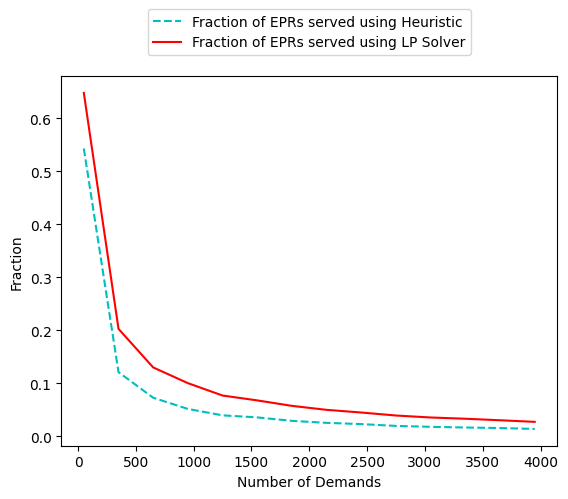

In [13]:
timeArray = np.arange(lowerBound, max_number_of_demands, step)

plt.plot(timeArray, average_eprres, color='c', label='Fraction of EPRs served using Heuristic', linestyle = 'dashed')
plt.plot(timeArray, average_eprres_lp, color='r', label='Fraction of EPRs served using LP Solver')

plt.xlabel("Number of Demands")
plt.ylabel("Fraction")
#plt.title("Demand Fullfilmet Schedule")

plt.legend()
plt.legend(bbox_to_anchor=(0.5, 1.2), loc='upper center')
plt.savefig('lp_heur_epr.png', bbox_inches='tight', dpi=500)
plt.show()

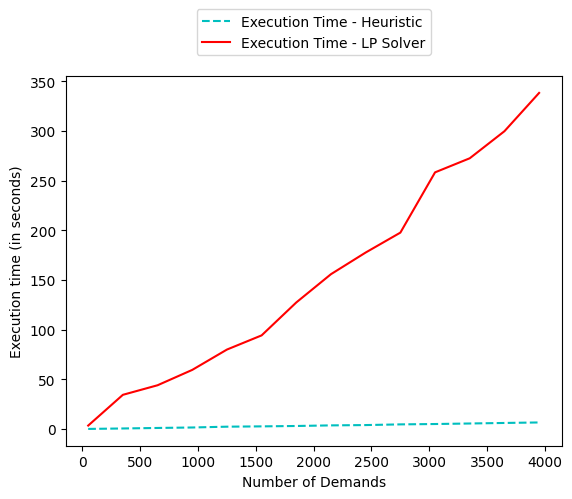

In [14]:
demand_sizes = [i for i in range(lowerBound, max_number_of_demands, step)]

#Plot execution times
plt.plot(demand_sizes, exec_tms_heur, color='c', label='Execution Time - Heuristic', linestyle = 'dashed')
plt.plot(demand_sizes, exec_tms_lp, color='r', label='Execution Time - LP Solver')

plt.xlabel("Number of Demands")
plt.ylabel("Execution time (in seconds)")
#plt.title("Demand Fullfilmet Schedule")

plt.legend()
plt.legend(bbox_to_anchor=(0.5, 1.2), loc='upper center')
plt.savefig('lp_heur_exec.png', bbox_inches='tight', dpi=500)
plt.show()

In [62]:
print(f'exec_tms_heur: {exec_tms_heur}')
print(f'exec_tms_lp: {exec_tms_lp}')
print(f'average_eprres: {average_eprres}')
print(f'average_eprres_lp: {average_eprres_lp}')
print(f'demand_sizes: {demand_sizes}')

exec_tms_heur: [0.0038507919998664875, 0.2243732080000882, 0.47807312500026455, 0.704590416999963, 0.984793874999923, 1.2325200420000328, 1.4576355829999557]
exec_tms_lp: [0.34326729100030207, 20.359939917000247, 33.5484294580001, 49.56842662500003, 61.72570545800045, 91.77138633300001, 103.906411166]
average_eprres: [0.7272727272727273, 0.0944206008583691, 0.05806737588652482, 0.04336922849977873, 0.030399322105709142, 0.025860547219770522, 0.02269345238095238]
average_eprres_lp: [0.7272727272727273, 0.15236051502145923, 0.10017730496453901, 0.07419973447411123, 0.05899798750132401, 0.049955869373345105, 0.043601190476190474]
demand_sizes: [10, 310, 610, 910, 1210, 1510, 1810]


In [1]:
import numpy as np
import matplotlib.pyplot as plt

max_number_of_demands = 4000
lowerBound = 50
step = 300

average_eprres= [0.5428571428571428, 0.12127894156560089, 0.07302353651176825, 0.05196078431372549, 0.0398527865404837, 0.0359818783760237, 0.02947292936536393, 0.025695265351832267, 0.023386034255599472, 0.019931172928018354, 0.018229393807239425, 0.01694915254237288, 0.015921347078029276, 0.014266622118275977]
exec_tms_heur = [0.0554475420003655, 0.5115202500001033, 1.026224541999909, 1.4977920840001389, 2.3083839589999116, 2.6259985420001613, 3.008295624999846, 3.62066195800071, 3.9354955830003746, 4.625799542000095, 4.987114500000644, 5.5186456250003175, 6.058216291999997, 6.56415670899969]
average_eprres_lp = [0.6476190476190476, 0.20286659316427783, 0.13015489841078254, 0.10056022408963586, 0.07718191377497371, 0.0680432131033281, 0.057726783793474366, 0.05020842406520251, 0.04518006148440931, 0.03952776981168148, 0.03580462276493676, 0.03345545311808044, 0.03059539968450787, 0.02759772803207484]
exec_tms_lp = [3.435256834000029, 34.38023016599982, 44.00156233399957, 59.4606797080005, 79.92026075000012, 94.19364866700016, 127.34746095799983, 155.80339275000006, 177.5806466240001, 197.60423404199992, 258.2545595009997, 272.418562459, 299.63776258300004, 338.1896040419997]
